In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# To display charts inline
%matplotlib inline


In [ ]:
#Load the datasets
purchase_df = pd.read_csv('QVI_purchase_behaviour.csv')
transaction_df = pd.read_excel('QVI_transaction_data.xlsx')

In [ ]:
#check missing values
print(purchase_df.info())
print(transaction_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264839 entries, 0 to 264838
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 264836 non-null  datetime64[ns]
 1   STORE_NBR            264836 non-null  float64       
 2   LYLTY_CARD_NBR       264836 non-null  float64       
 3   TXN_ID               264836 non-null  float64       
 4   PROD_NBR             264836 non-null  float64       
 5   Update_Product_Name  264836 non-null  object        
 6   PROD_QTY             264838 

In [ ]:
#Description Statistics
print(transaction_df.describe())
transaction_df.isnull().sum()

                                DATE     STORE_NBR  LYLTY_CARD_NBR  \
count                         264836  264836.00000    2.648360e+05   
mean   2018-12-30 00:52:12.879215360     135.08011    1.355495e+05   
min              2018-07-01 00:00:00       1.00000    1.000000e+03   
25%              2018-09-30 00:00:00      70.00000    7.002100e+04   
50%              2018-12-30 00:00:00     130.00000    1.303575e+05   
75%              2019-03-31 00:00:00     203.00000    2.030942e+05   
max              2019-06-30 00:00:00     272.00000    2.373711e+06   
std                              NaN      76.78418    8.057998e+04   

             TXN_ID       PROD_NBR       PROD_QTY      TOT_SALES  
count  2.648360e+05  264836.000000  264838.000000  264838.000000  
mean   1.351583e+05      56.583157       1.907324       7.304259  
min    1.000000e+00       1.000000       1.000000       1.500000  
25%    6.760150e+04      28.000000       2.000000       5.400000  
50%    1.351375e+05      56.000000

,0
DATE,3
STORE_NBR,3
LYLTY_CARD_NBR,3
TXN_ID,3
PROD_NBR,3
Update_Product_Name,3
PROD_QTY,1
TOT_SALES,1


In [ ]:
#merge datasets
merged_df = pd.merge(transaction_df, purchase_df, on='LYLTY_CARD_NBR', how='left')
print(merged_df)

             DATE  STORE_NBR  LYLTY_CARD_NBR    TXN_ID  PROD_NBR  \
0      2018-07-01        4.0          4074.0    2982.0      57.0   
1      2018-07-01        4.0          4149.0    3333.0      16.0   
2      2018-07-01        4.0          4196.0    3539.0      24.0   
3      2018-07-01        5.0          5026.0    4525.0      42.0   
4      2018-07-01        7.0          7215.0    7176.0      16.0   
...           ...        ...             ...       ...       ...   
264834 2019-06-22      208.0        208205.0  207318.0      37.0   
264835 2019-06-22      264.0        264149.0  262909.0      25.0   
264836        NaT        NaN             NaN       NaN       NaN   
264837        NaT        NaN             NaN       NaN       NaN   
264838        NaT        NaN             NaN       NaN       NaN   

                             Update_Product_Name  PROD_QTY  TOT_SALES  \
0         Old El Paso Salsa Dip Tomato Mild 300g       1.0        5.1   
1       Smiths Crinkle Chips Salt & V

In [ ]:
transaction_df.dropna(inplace=True)
transaction_df.isnull().sum()

,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
Update_Product_Name,0
PROD_QTY,0
TOT_SALES,0


In [ ]:
#Keep only chip-related products
merged_df = merged_df[merged_df['Update_Product_Name'].str.contains("chip|chips", case=False, na=False)]

In [ ]:
# Remove outlier customer who bought 200 units
merged_df = merged_df[merged_df['LYLTY_CARD_NBR'] != 226000]

In [ ]:
# Check for missing dates
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
full_dates = pd.date_range(start="2018-07-01", end="2019-06-30")
actual_dates = merged_df['DATE'].dt.normalize().unique()
missing_dates = [date for date in full_dates if date not in actual_dates]
print("Missing dates:", missing_dates)

Missing dates: [Timestamp('2018-12-25 00:00:00')]


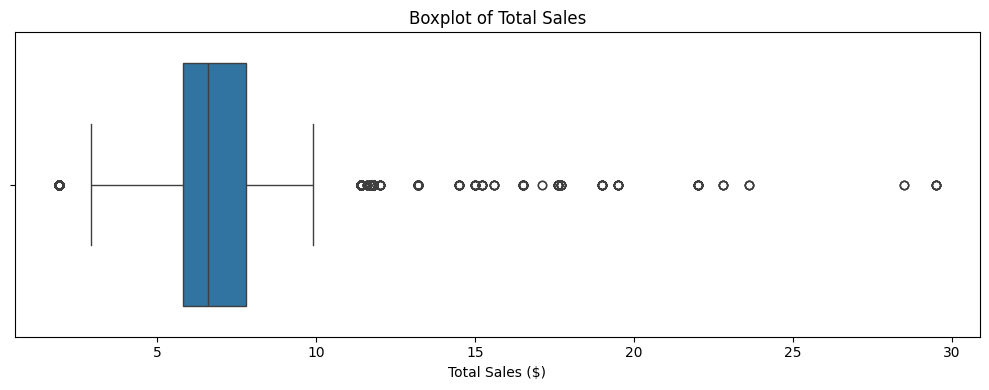

In [ ]:
# Boxplot of sales to check outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=merged_df['TOT_SALES'])
plt.title("Boxplot of Total Sales")
plt.xlabel("Total Sales ($)")
plt.tight_layout()
plt.show()

In [ ]:
# Remove outliers using IQR
Q1 = merged_df['TOT_SALES'].quantile(0.25)
Q3 = merged_df['TOT_SALES'].quantile(0.75)
IQR = Q3 - Q1
merged_df = merged_df[(merged_df['TOT_SALES'] >= Q1 - 1.5 * IQR) &
                      (merged_df['TOT_SALES'] <= Q3 + 1.5 * IQR)]


In [ ]:
# Extract PACK_SIZE from PROD_NAME
merged_df['PACK_SIZE'] = merged_df['Update_Product_Name'].str.extract(r'(\d+)').astype(float)


In [ ]:
# Extract and clean BRAND
merged_df['BRAND'] = merged_df['Update_Product_Name'].str.extract(r'^([A-Za-z]+)')
brand_fix = {'RED': 'RRD', 'SNBTS': 'SUNBITES', 'WW': 'WOOLWORTHS', 'SMITH': 'SMITHS',
             'NCC': 'NATURAL', 'DORITO': 'DORITOS', 'INFZNS': 'INFUZIONS', 'GRAIN': 'GRNWVES'}
merged_df['BRAND'].replace(brand_fix, inplace=True)


<ipython-input-14-ed1ba893524e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['BRAND'].replace(brand_fix, inplace=True)


<ipython-input-15-5a280820b557>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = merged_df.resample('M', on='DATE')['TOT_SALES'].sum()


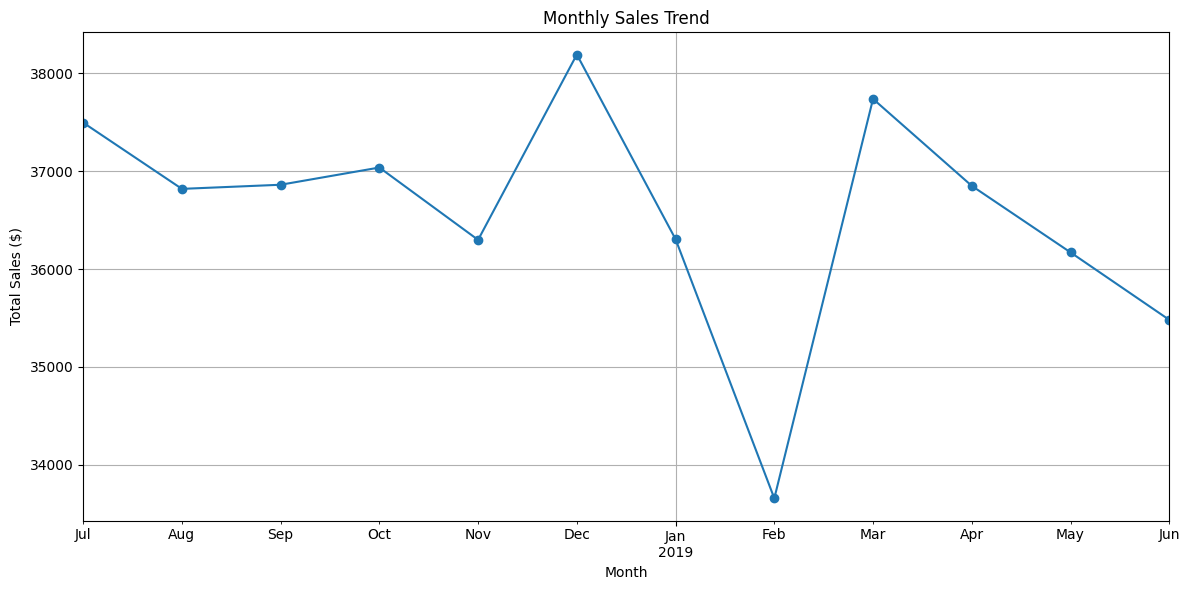

In [ ]:
# Monthly sales trend
monthly_sales = merged_df.resample('M', on='DATE')['TOT_SALES'].sum()
monthly_sales.plot(kind='line', marker='o', figsize=(12, 6), title='Monthly Sales Trend')
plt.ylabel('Total Sales ($)')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Total sales by customer segment
sales_by_type = (merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES']
                 .sum()
                 .reset_index()
                 .sort_values(by='TOT_SALES', ascending=False))
print(sales_by_type)


                 LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
6           OLDER FAMILIES           Budget    38481.0
13                RETIREES       Mainstream    35074.7
19   YOUNG SINGLES/COUPLES       Mainstream    33518.9
15          YOUNG FAMILIES           Budget    31905.7
10   OLDER SINGLES/COUPLES       Mainstream    30728.1
9    OLDER SINGLES/COUPLES           Budget    30615.1
11   OLDER SINGLES/COUPLES          Premium    29595.4
12                RETIREES           Budget    25493.5
7           OLDER FAMILIES       Mainstream    24268.3
16          YOUNG FAMILIES       Mainstream    21895.2
14                RETIREES          Premium    21268.2
1   MIDAGE SINGLES/COUPLES       Mainstream    19857.4
17          YOUNG FAMILIES          Premium    19736.2
8           OLDER FAMILIES          Premium    18352.9
18   YOUNG SINGLES/COUPLES           Budget    14735.6
2   MIDAGE SINGLES/COUPLES          Premium    13317.3
20   YOUNG SINGLES/COUPLES          Premium    10088.2
0   MIDAGE

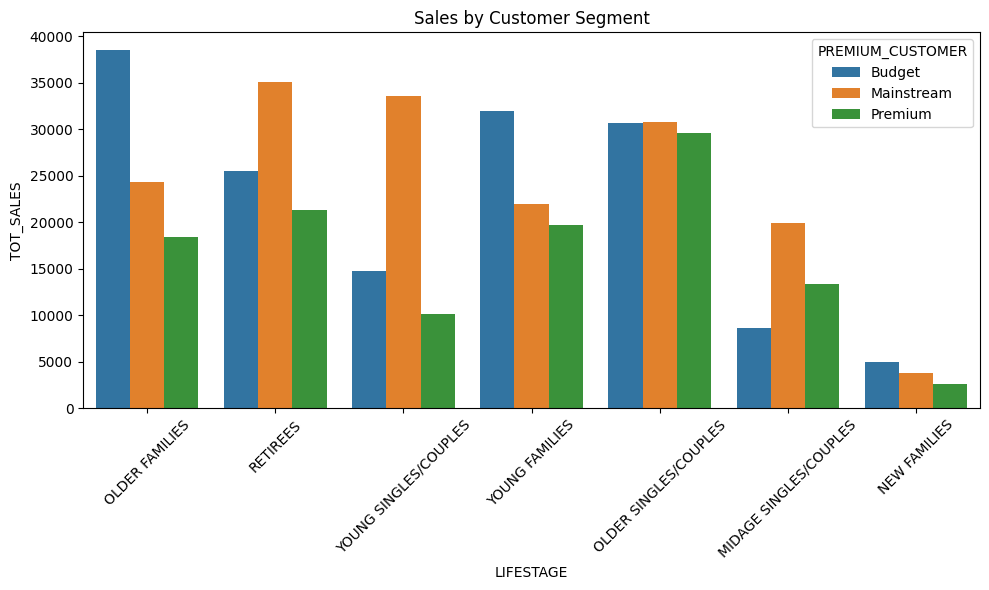

In [ ]:
# 📊 Bar chart of customer segment sales
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_type, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.title('Sales by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# 🔢 Average units per customer
avg_units = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum() / \
            merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()
print("Average units per customer:\n", avg_units)


Average units per customer:
 LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              3.020095
                        Mainstream          3.031686
                        Premium             3.026134
NEW FAMILIES            Budget              2.636531
                        Mainstream          2.527316
                        Premium             2.537415
OLDER FAMILIES          Budget              3.810909
                        Mainstream          3.869010
                        Premium             3.843923
OLDER SINGLES/COUPLES   Budget              3.041424
                        Mainstream          3.126477
                        Premium             3.077309
RETIREES                Budget              2.879181
                        Mainstream          2.856139
                        Premium             2.848951
YOUNG FAMILIES          Budget              3.718640
                        Mainstream          3.690355
                        Premi

In [ ]:
# 💲 Average price per unit
avg_price = merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum() / \
            merged_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum()
print("Average price per unit:\n", avg_price)


Average price per unit:
 LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              3.371037
                        Mainstream          3.517697
                        Premium             3.382601
NEW FAMILIES            Budget              3.498600
                        Mainstream          3.531109
                        Premium             3.479759
OLDER FAMILIES          Budget              3.338046
                        Mainstream          3.339981
                        Premium             3.297323
OLDER SINGLES/COUPLES   Budget              3.446094
                        Mainstream          3.414992
                        Premium             3.442126
RETIREES                Budget              3.484623
                        Mainstream          3.450536
                        Premium             3.480314
YOUNG FAMILIES          Budget              3.352848
                        Mainstream          3.346355
                        Premium  

In [ ]:
# 🎯 Brand affinity: Mainstream + Young Singles/Couples
segment = merged_df[(merged_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") &
                    (merged_df['PREMIUM_CUSTOMER'] == "Mainstream")]
segment_brand_share = segment['BRAND'].value_counts(normalize=True)
other_brand_share = merged_df[~merged_df.index.isin(segment.index)]['BRAND'].value_counts(normalize=True)
brand_affinity = (segment_brand_share / other_brand_share).dropna().sort_values(ascending=False)
print("Brand Affinity:\n", brand_affinity)


Brand Affinity:
 BRAND
Doritos       1.286385
Cobs          1.217147
Tostitos      1.213476
Thins         1.125839
French        0.723629
Smiths        0.713365
Natural       0.699358
WOOLWORTHS    0.496231
Name: proportion, dtype: float64


In [ ]:
# Pack size affinity
segment_qty = segment['PROD_QTY'].sum()
other = merged_df[~merged_df.index.isin(segment.index)]
other_qty = other['PROD_QTY'].sum()
segment_pack_share = segment.groupby('PACK_SIZE')['PROD_QTY'].sum() / segment_qty
other_pack_share = other.groupby('PACK_SIZE')['PROD_QTY'].sum() / other_qty
pack_affinity = (segment_pack_share / other_pack_share).dropna().sort_values(ascending=False)
print("Pack Size Affinity:\n", pack_affinity)


Pack Size Affinity:
 PACK_SIZE
380.0    2.319916
330.0    2.247313
110.0    1.227404
150.0    1.213443
170.0    1.071249
175.0    0.948822
160.0    0.532697
200.0    0.494835
Name: PROD_QTY, dtype: float64


In [ ]:
merged_df.to_csv("QVI_cleaned_data.csv", index=False)
